# Create bar plots from the paper

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import FormatStrFormatter

In [87]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

In [88]:
def translate(method, proj):
    translate_dict = {
        'rff': 'RFF',
        'srf': 'SRF',
        'maclaurin': 'Opt. Macl.',
        'maclaurin_p': 'Class. Macl.',
        'gaussian': 'Gauss.',
        'srht': 'TensorSRHT',
        'rademacher': 'Radem.',
        'countsketch': 'TensorSk.',
        'poly_sketch': '',
        'poly_sketch': ''
    }
    
    if method == 'rff':
        translate_dict['srht'] = 'Orth.'
    elif method == 'srf':
        translate_dict['srht'] = 'Orth.'
        
    if method == 'ts':
        return translate_dict[proj]
        
    return ' '.join([translate_dict[method], translate_dict[proj]])

In [89]:
def translate_error(err, regression=False):
    err_dict = {
        'k_rel_frob_error': r'Rel. Frob. Error',
        'test_mnll': r'MNLL',
        'test_kl': r'KL Div.' #  $(\downarrow)$
    }
    
    if regression:
        err_dict['test_error'] = r'Norm. MSE'
    else:
        err_dict['test_error'] = r'Class. Error'
        
    return err_dict[err]

In [90]:
def get_norm_scores(df, config, error_field):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel_norm = df_sel[(df_sel['hier'] == 0) & (df_sel['comp'] == 0)]
    
    Ds = np.sort(df_sel_norm['D'].unique())
    df_sel_norm = df_sel_norm.groupby(['D'])[error_field]
    
    means = df_sel_norm.mean().values
    
    return means[0]

In [91]:
def plot_bar(ax, df, config, error_field, data_offset, method_offset, width=0.2):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]

    df_sel_norm = df_sel[(df_sel['hier'] == config['hier']) & (df_sel['comp'] == config['complex'])]
    
    Ds = np.sort(df_sel_norm['D'].unique())
    df_sel_norm = df_sel_norm.groupby(['D'])[error_field]
    
    X_vals = np.arange(len(Ds))
    #X_vals = X_vals - X_vals.mean()
    
    means = df_sel_norm.mean().values
    stds = df_sel_norm.std().values
    
    # print(df['dataset'].iloc[0], config, means)
    
    # each method is plotted len(X_vals) times for a dataset
    bar_positions = data_offset + X_vals*1.3 + method_offset * width
    
    if data_offset == 0:
        label = translate(config['method'], config['proj'])
        if config['complex']:
            label += ' Comp.'
    else:
        label = ''
    
    ax.bar(
        bar_positions,
        means,
        yerr=stds,
        error_kw=dict(lw=1, capsize=1, capthick=1),
        align='center',
        color = config['color'],
        width = width,
        label=label
    )

In [92]:
def plot_csv(ax, csvs, configs, error_field='rel_frob_error', regression=False, y_lim=(0, 0.6), logscale=False):
    bar_positions = []
    data_names = []
    
    for i, csv_file in enumerate(csvs):
        # go through datasets
        
        df = pd.read_csv(csv_file)

        dimension = int(csv_file.split('/')[-1].split('_')[-2][1:])
        n_samples = int(csv_file.split('/')[-1].split('_')[-1].split('.')[0][1:])

        dataset_name = df['dataset'].iloc[0]
        data_names.append('')
        # \nN={}\nd={}
        data_names.append('1d    3d    5d\n{}'.format(dataset_name, n_samples, dimension))
        data_names.append('')

        if dataset_name == 'MNIST' or dataset_name == 'FashionMNIST':
            df = df[df['D'] >= 1024]

        df['proj'] = df['proj'].apply(lambda x: x.split('_')[0] if x.split('_')[0] != 'rff' else x)
        
        # d, 3d, 5d
        dim_indices = [0, 2, 4]
        Ds = np.sort(df['D'].unique())
        Ds = np.array([Ds[idx] for idx in dim_indices])
        df = df[df['D'].isin(Ds)]
        
        # obtain normalization scores per dataset
        norm_conf = {'method': 'rff', 'proj': 'gaussian'}
        # norm_score = get_norm_scores(df, norm_conf, error_field)
        # df[error_field] = df[error_field] / norm_score
        
        if error_field == 'test_error' and regression:
            df[error_field] = df[error_field] / df['test_label_var']
        
        width = 0.15
        data_offset = i * (len(dim_indices)+0.5)*1.3
        bar_position = data_offset + ((len(dim_indices)-1)*1.3 + (len(configs)-1)*width)/2
        bar_positions += [bar_position-1.3, bar_position, bar_position+1.3]
        
        for j, config in enumerate(configs):
            # go through methods
            # i = dataset offset
            # j = small method offset
            plot_bar(ax, df, config, error_field, data_offset, j, width)
            
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(data_names)
    ax.set_xlim(bar_positions[0]-1.5, bar_positions[-1]+1.5)
    if logscale:
        ax.set_yscale('log')
    else:
        ax.set_ylim(*y_lim)
    ax.set_ylabel(translate_error(error_field, regression))
    # ax.legend(loc='upper center', ncol=8)

## Gaussian Kernel

In [99]:
# colors = plt.get_cmap('hsv')(np.linspace(0, 1, 10))
reds = plt.get_cmap('YlOrRd')(np.linspace(0.4, 1, 3))
blues = plt.get_cmap('GnBu')(np.linspace(0.4, 1, 4))

In [100]:
configs = [
    {'method': 'rff', 'proj': 'gaussian', 'complex': False, 'hier': False, 'color': reds[0]},
    {'method': 'rff', 'proj': 'srht', 'complex': False, 'hier': False, 'color': reds[1]},
    {'method': 'rff', 'proj': 'srht', 'complex': True, 'hier': False, 'color': reds[2]},
    {'method': 'maclaurin', 'proj': 'countsketch', 'complex': False, 'hier': False, 'color': blues[0]},
    {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'hier': False, 'color': blues[1]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'hier': False, 'color': blues[2]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'hier': False, 'color': blues[3]}
]

### Regression

In [22]:
csv_files = [
    '../csv/gaussian_approx/Boston_d16_n506.csv',
    '../csv/gaussian_approx/Concrete_d8_n1030.csv',
    '../csv/gaussian_approx/Energy_d8_n768.csv',
    '../csv/gaussian_approx/kin8nm_d8_n8192.csv',
    '../csv/gaussian_approx/Naval_d16_n11934.csv',
    '../csv/gaussian_approx/Powerplant_d4_n9568.csv',
    '../csv/gaussian_approx/Protein_d16_n45730.csv',
    '../csv/gaussian_approx/Yacht_d8_n308.csv'
]

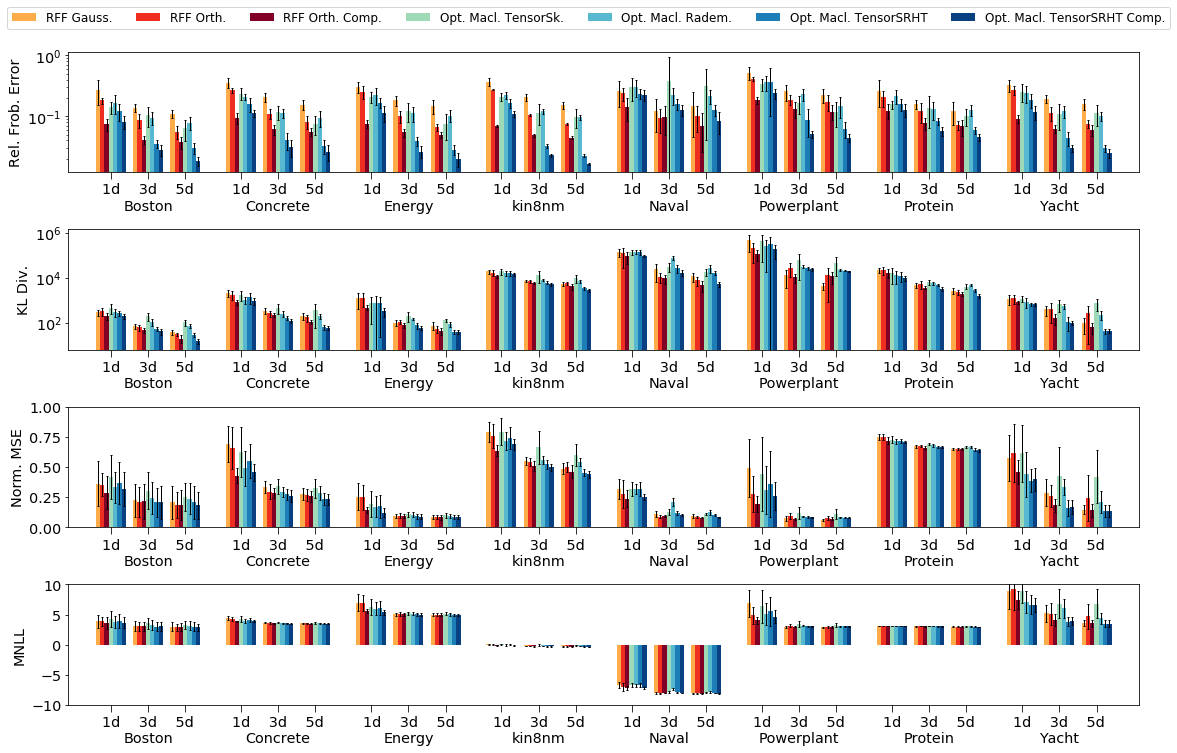

In [23]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 10))
plot_csv(axes[0], csv_files, configs, error_field='k_rel_frob_error', y_lim=(0, 0.6), logscale=True)
plot_csv(axes[1], csv_files, configs, error_field='test_kl', y_lim=(0, 1.0), logscale=True)
plot_csv(axes[2], csv_files, configs, error_field='test_error', y_lim=(0, 1.0), logscale=False, regression=True)
plot_csv(axes[3], csv_files, configs, error_field='test_mnll', y_lim=(-10, 10), logscale=False, regression=True)
handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=7, bbox_to_anchor = (0,0.2,1.025,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/rbf_approx/regression_no_comp.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

### Classification

In [20]:
csv_files = [
    # '../csv/gaussian_approx/Adult_d128_n48842.csv',
    '../csv/gaussian_approx/Cod_rna_d8_n331152.csv',
    '../csv/gaussian_approx/Covertype_d64_n581012.csv',
    '../csv/gaussian_approx/Drive_d64_n58509.csv',
    # '../csv/gaussian_approx/EEG_d16_n14980.csv',
    '../csv/gaussian_approx/FashionMNIST_d1024_n70000.csv',
    # '../csv/gaussian_approx/Letter_d16_n20000.csv',
    '../csv/gaussian_approx/Magic_d16_n19020.csv',
    '../csv/gaussian_approx/Miniboo_d64_n130064.csv',
    '../csv/gaussian_approx/MNIST_d1024_n70000.csv',
    '../csv/gaussian_approx/Mocap_d64_n78095.csv'
]

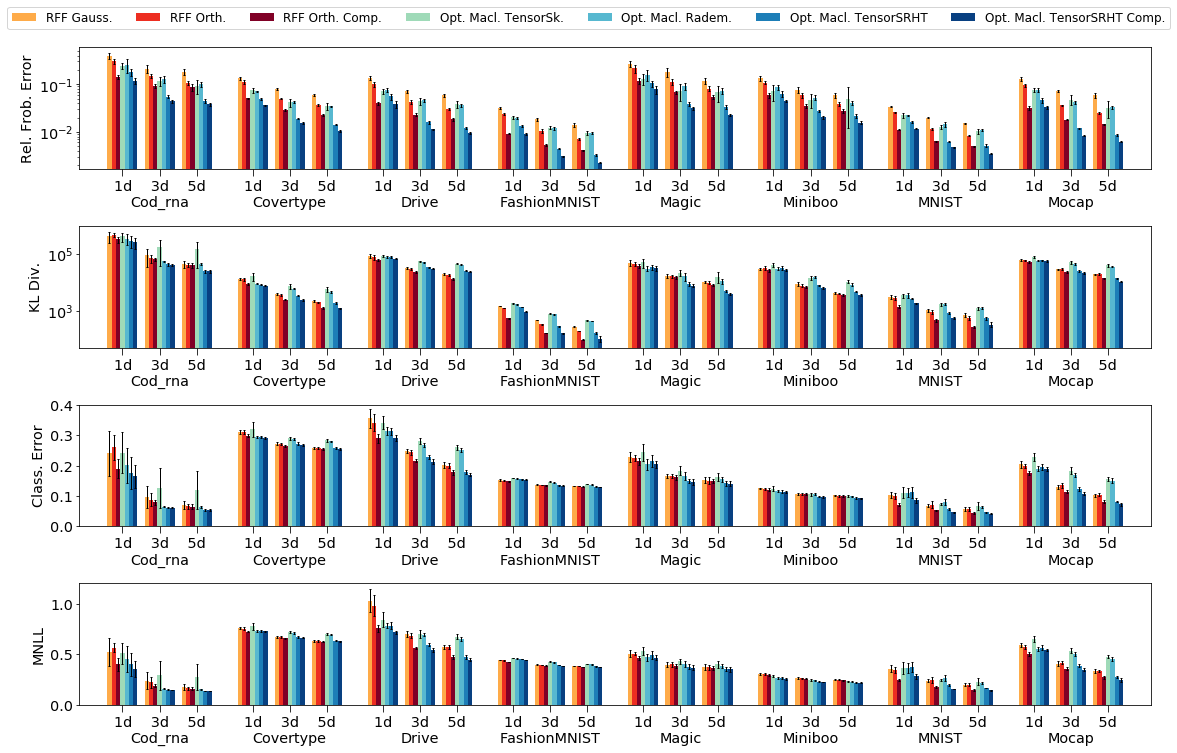

In [21]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 10))
plot_csv(axes[0], csv_files, configs, error_field='k_rel_frob_error', y_lim=(0, 0.4), logscale=True)
plot_csv(axes[1], csv_files, configs, error_field='test_kl', logscale=True)
plot_csv(axes[2], csv_files, configs, error_field='test_error', y_lim=(0, 0.4), logscale=False, regression=False)
plot_csv(axes[3], csv_files, configs, error_field='test_mnll', y_lim=(0, 1.2))

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=7, bbox_to_anchor = (0,0.2,1.005,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/rbf_approx/classification_no_comp.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

## Polynomial Kernel

In [101]:
configs = [
    {'method': 'srf', 'proj': 'gaussian', 'complex': False, 'hier': False, 'color': reds[0]},
    {'method': 'srf', 'proj': 'srht', 'complex': False, 'hier': False, 'color': reds[1]},
    {'method': 'srf', 'proj': 'srht', 'complex': True, 'hier': False, 'color': reds[2]},
    {'method': 'maclaurin', 'proj': 'countsketch', 'complex': False, 'hier': False, 'color': blues[0]},
    {'method': 'maclaurin', 'proj': 'rademacher', 'complex': False, 'hier': False, 'color': blues[1]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'hier': False, 'color': blues[2]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'hier': False, 'color': blues[3]}
]

### Regression

In [28]:
csv_files = [
    '../csv/poly20_approx/Boston_d16_n506.csv',
    '../csv/poly20_approx/Concrete_d8_n1030.csv',
    '../csv/poly20_approx/Energy_d8_n768.csv',
    '../csv/poly20_approx/kin8nm_d8_n8192.csv',
    '../csv/poly20_approx/Naval_d16_n11934.csv',
    '../csv/poly20_approx/Powerplant_d4_n9568.csv',
    '../csv/poly20_approx/Protein_d16_n45730.csv',
    '../csv/poly20_approx/Yacht_d8_n308.csv'
]

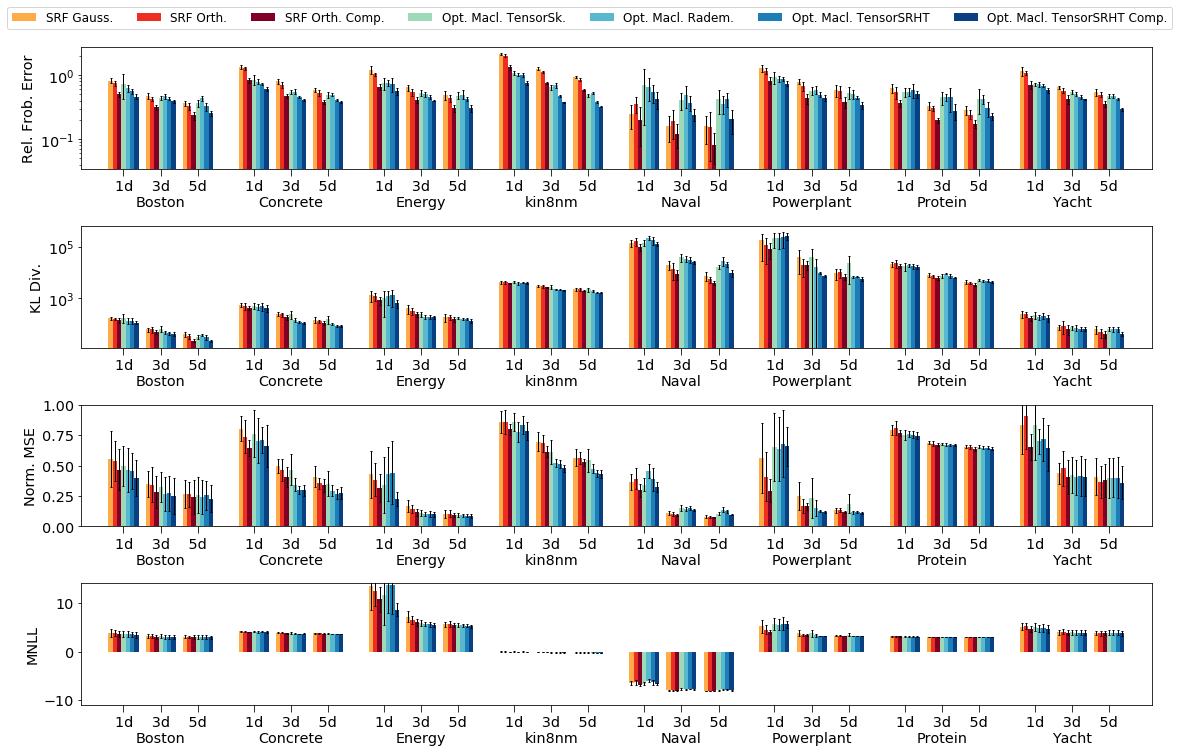

In [29]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 10))
plot_csv(axes[0], csv_files, configs, error_field='k_rel_frob_error', y_lim=(0, 0.4), logscale=True)
plot_csv(axes[1], csv_files, configs, error_field='test_kl', logscale=True)
plot_csv(axes[2], csv_files, configs, error_field='test_error', y_lim=(0, 1), logscale=False, regression=True)
plot_csv(axes[3], csv_files, configs, error_field='test_mnll', y_lim=(-11, 14))

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=7, bbox_to_anchor = (0,0.2,1.005,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly_approx/regression_no_comp.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

### Classification

In [102]:
csv_files = [
    # '../csv/poly20_approx/Adult_d128_n48842.csv',
    '../csv/poly20_approx/Codrna_d8_n331152.csv',
    '../csv/poly20_approx/Covertype_d64_n581012.csv',
    '../csv/poly20_approx/Drive_d64_n58509.csv',
    # '../csv/poly20_approx/EEG_d16_n14980.csv',
    '../csv/poly20_approx/FashionMNIST_d1024_n70000.csv',
    # '../csv/poly20_approx/Letter_d16_n20000.csv',
    '../csv/poly20_approx/Magic_d16_n19020.csv',
    '../csv/poly20_approx/Miniboo_d64_n130064.csv',
    '../csv/poly20_approx/MNIST_d1024_n70000.csv',
    '../csv/poly20_approx/Mocap_d64_n78095.csv'
]

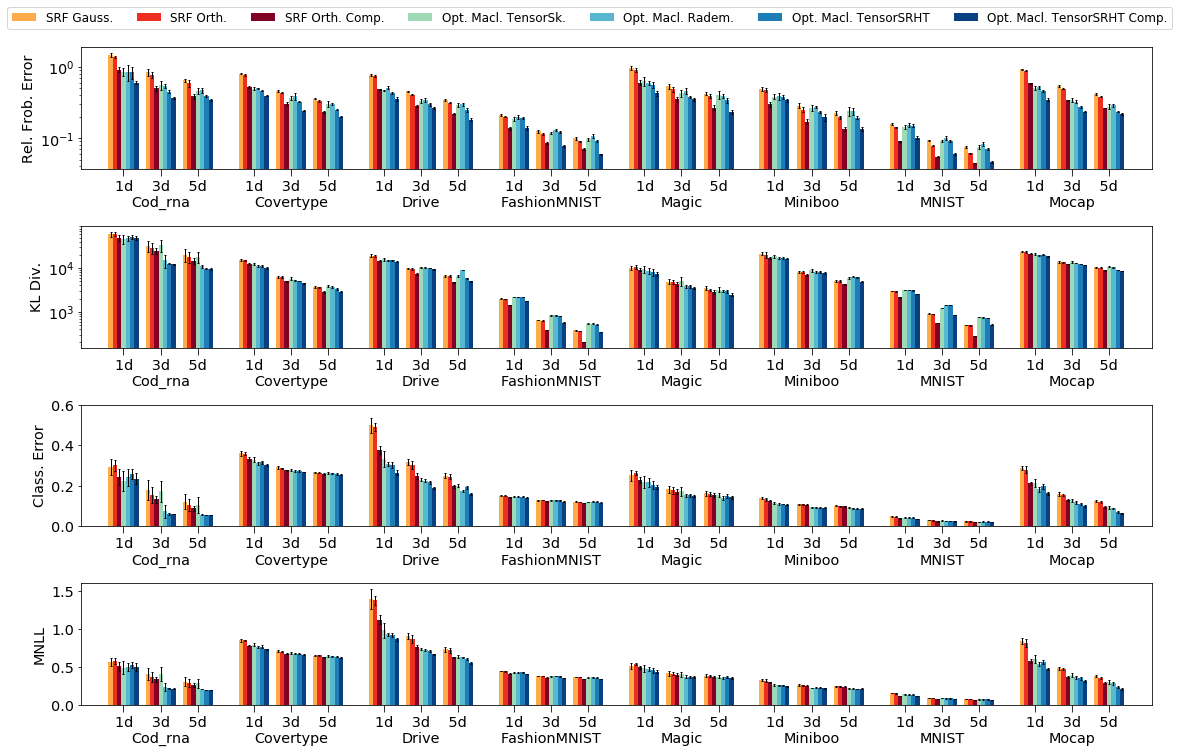

In [103]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(16, 10))
plot_csv(axes[0], csv_files, configs, error_field='k_rel_frob_error', y_lim=(0, 1.0), logscale=True)
plot_csv(axes[1], csv_files, configs, error_field='test_kl', logscale=True)
plot_csv(axes[2], csv_files, configs, error_field='test_error', y_lim=(0, 0.6), logscale=False, regression=False)
plot_csv(axes[3], csv_files, configs, error_field='test_mnll', y_lim=(0, 1.6))

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=7, bbox_to_anchor = (0,0.2,1.005,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly_approx/classification_no_comp.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

## Simple Frobenius error comparison

In [32]:
def plot_bar(ax, df, config, error_field, data_offset, method_offset, width=0.2):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]

    df_sel_norm = df_sel[(df_sel['hier'] == config['hier']) & (df_sel['comp'] == config['complex'])]
    
    Ds = np.sort(df_sel_norm['D'].unique())
    df_sel_norm = df_sel_norm.groupby(['D'])[error_field]
    
    X_vals = np.arange(len(Ds))
    #X_vals = X_vals - X_vals.mean()
    
    means = df_sel_norm.mean().values
    stds = df_sel_norm.std().values
    
    # print(df['dataset'].iloc[0], config, means)
    
    # each method is plotted len(X_vals) times for a dataset
    bar_positions = data_offset + X_vals*2 + method_offset * width
    
    if data_offset == 0:
        label = translate(config['method'], config['proj'])
        if config['complex']:
            label += ' Comp.'
            if error_field == 'k_rel_frob_error':
                label += ' (Disc. Imag.)'
            else:
                label += ' (Keep Imag.)'
        if config['hier']:
            label += ' Hier.'
    else:
        label = ''
    
    ax.bar(
        bar_positions,
        means,
        yerr=stds,
        error_kw=dict(lw=1, capsize=1, capthick=1),
        align='center',
        color = config['color'],
        width = width,
        label=label
    )

In [33]:
def plot_csv(ax, csvs, configs, error_field='rel_frob_error', regression=False, y_lim=(0, 0.6), logscale=False):
    bar_positions = []
    data_names = []
    
    for i, csv_file in enumerate(csvs):
        # go through datasets
        
        df = pd.read_csv(csv_file)

        dimension = int(csv_file.split('/')[-1].split('_')[-2][1:])
        n_samples = int(csv_file.split('/')[-1].split('_')[-1].split('.')[0][1:])

        dataset_name = df['dataset'].iloc[0]
        data_names.append('')
        # \nN={}\nd={}
        data_names.append('1d    3d    5d\n{}'.format(dataset_name, n_samples, dimension))
        data_names.append('')

        if dataset_name == 'MNIST' or dataset_name == 'FashionMNIST':
            df = df[df['D'] >= 1024]

        df['proj'] = df['proj'].apply(lambda x: x.split('_')[0] if x.split('_')[0] != 'rff' else x)
        
        # d, 3d, 5d
        #dim_indices = [0, 1, 2, 3, 4]
        dim_indices = [0, 1]
        Ds = np.sort(df['D'].unique())
        Ds = np.array([Ds[idx] for idx in dim_indices])
        df = df[df['D'].isin(Ds)]
        
        # obtain normalization scores per dataset
        norm_conf = {'method': 'rff', 'proj': 'gaussian'}
        # norm_score = get_norm_scores(df, norm_conf, error_field)
        # df[error_field] = df[error_field] / norm_score
        
        if error_field == 'test_error' and regression:
            df[error_field] = df[error_field] / df['test_label_var']
        
        width = 0.15
        data_offset = i * (len(dim_indices)+0.5)*2
        bar_position = data_offset + ((len(dim_indices)-1)*2 + (len(configs)-1)*width)/2
        bar_positions = [bar_position-1, bar_position+1]
        
        for j, config in enumerate(configs):
            # go through methods
            # i = dataset offset
            # j = small method offset
            if config['complex'] and config['complex_err'] and error_field == 'k_rel_frob_error':
                plot_bar(ax, df, config, error_field + '_comp', data_offset, j, width)
            else:
                plot_bar(ax, df, config, error_field, data_offset, j, width)
                
            
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(['1d', '2d'])
    ax.set_xlim(bar_positions[0]-1.0, bar_positions[-1]+1.0)
    if logscale:
        ax.set_yscale('log')
    else:
        ax.set_ylim(*y_lim)
    ax.set_title('p={}'.format(int(df['degree'].iloc[0])))
    # ax.set_ylabel(translate_error(error_field, regression))
    # ax.legend(loc='upper center', ncol=8)

In [34]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

In [35]:
# colors = plt.get_cmap('hsv')(np.linspace(0, 1, 10))
reds = plt.get_cmap('RdPu')(np.linspace(0.4, 1, 5))
blues = plt.get_cmap('GnBu')(np.linspace(0.2, 1, 5))

In [36]:
configs = [
    {'method': 'poly_sketch', 'proj': 'rademacher', 'complex': False, 'hier': False, 'color': reds[0]},
    {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'hier': False, 'color': reds[1]},
    {'method': 'poly_sketch', 'proj': 'srht', 'complex': False, 'hier': True, 'color': reds[2]},
    {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'complex_err': True, 'hier': False, 'color': reds[3]},
    {'method': 'poly_sketch', 'proj': 'srht', 'complex': True, 'complex_err': False, 'hier': False, 'color': reds[4]},
    {'method': 'maclaurin_p', 'proj': 'rademacher', 'complex': False, 'hier': False, 'color': blues[0]},
    {'method': 'maclaurin_p', 'proj': 'srht', 'complex': False, 'hier': False, 'color': blues[1]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': False, 'hier': False, 'color': blues[2]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'complex_err': True, 'hier': False, 'color': blues[3]},
    {'method': 'maclaurin', 'proj': 'srht', 'complex': True, 'complex_err': False, 'hier': False, 'color': blues[4]},
]

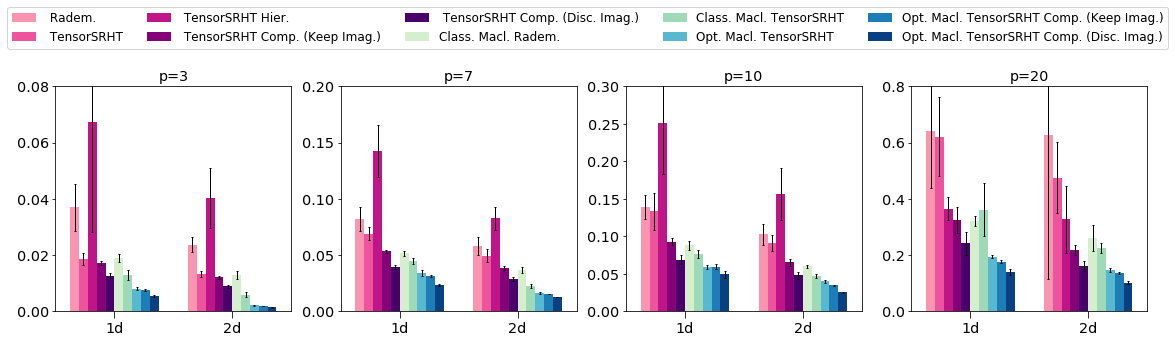

In [85]:
csv_files = [
    '../csv/poly3_approx/FashionMNIST_d1024_n70000.csv',
    '../csv/poly7_approx/FashionMNIST_d1024_n70000.csv',
    '../csv/poly10_approx/FashionMNIST_d1024_n70000.csv',
    '../csv/poly20_approx/FashionMNIST_d1024_n70000.csv'
]

fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))
plot_csv(axes[0], [csv_files[0]], configs, error_field='k_rel_frob_error', y_lim=(0, 0.08), logscale=False)
plot_csv(axes[1], [csv_files[1]], configs, error_field='k_rel_frob_error', y_lim=(0, 0.2), logscale=False)
plot_csv(axes[2], [csv_files[2]], configs, error_field='k_rel_frob_error', y_lim=(0, 0.3), logscale=False)
plot_csv(axes[3], [csv_files[3]], configs, error_field='k_rel_frob_error', y_lim=(0, 0.8), logscale=False)

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
legend = plt.figlegend(handles=handles, labels=labels, loc='upper center', ncol=5, bbox_to_anchor = (0,0.35,1.01,0.85), bbox_transform=plt.gcf().transFigure)
plt.savefig('../figures/poly_approx/frob_comparison_fmnist.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()